**Descrição**

Usa modanet:anotações para treinar modelo a

content/drive/My Drive/TCC/paperdoll/photos.lmdb

/content/drive/My Drive/TCC/modanet/modanet/annotations

ROOT_DIR, "Mask_RCNN-master"

TCC/paperdoll/data/chictopia/chictopia.sqlite3?mode=ro

## Imports

In [ ]:
import os
import sys
import copy
import json
import math
import re
import time
import datetime
import skimage.draw
import numpy as np
import cv2
import itertools
import logging
import random
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
%matplotlib inline 
from google.colab import drive
drive.mount('/content/drive')

# Directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/TCC/")
MODA_DIR = os.path.join(ROOT_DIR, 'modanet/modanet/annotations/')
RCNN_DIR = os.path.join(ROOT_DIR, "Mask_RCNN-master")
COCO_WEIGHTS_PATH = os.path.join(RCNN_DIR, 'mask_rcnn_coco.h5')
CUSTOM_DIR = os.path.join('/content/drive/My Drive/UFRN/FASHION/')

# Import Mask RCNN from local folder
sys.path.append(RCNN_DIR)  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Paperdoll
import io
import lmdb
import sqlite3
import pandas as pd
from PIL import Image
from IPython.display import display

# Directory to save logs and trained model
MODEL_DIR = os.path.join(RCNN_DIR, "logs")

# Local path to trained weights COCO file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
# if not os.path.exists('COCO_MODEL_PATH'):
#    utils.download_trained_weights(COCO_MODEL_PATH)
weights_path = os.path.join(ROOT_DIR, 'Mask_RCNN-master/mask_rcnn_coco.h5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


## Get Images annotated

### Paperdoll Dataset 

Tutorial: https://github.com/kyamagu/paperdoll/blob/master/data/chictopia/usage.ipynb

#### Read pictures from database

In [ ]:
class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
  
    def __len__(self):
        return self.env.stat()['entries']

In [ ]:
# Photo URL is "http://images{N}.chictopia.com" + path, where N is one of {0, 1, 2, 3}
db = sqlite3.connect('file:/content/drive/My Drive/TCC/paperdoll/data/chictopia/chictopia.sqlite3?mode=ro', uri=True)
photos = pd.read_sql("""
          SELECT *,
          'http://images2.chictopia.com/' || path AS url
          FROM photos
          WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
          """, con=db)
print('photos = %d' % (len(photos)))
photos.head()

photos = 1100987


,id,post_id,path,status,file_file_name,file_file_size,file_content_type,file_updated_at,width,height,created_at,updated_at,url
0,1,61,/photos/thefashbot/1930972049/1930972049_400.jpg,2,open-uri20120907-29328-3yd0mp,122564,image/jpeg,2012-09-07 23:07:38.719079,400,600,2012-09-07 23:07:38.441357,2012-09-07 23:07:39.456904,http://images2.chictopia.com//photos/thefashbo...
1,2,73,/photos/thefashbot/3613535083/3613535083_400.jpg,2,open-uri20120907-29328-1szdum6,119821,image/jpeg,2012-09-07 23:07:45.966209,400,600,2012-09-07 23:07:45.721208,2012-09-07 23:07:46.438801,http://images2.chictopia.com//photos/thefashbo...
2,3,73,/photos/thefashbot/3613535083/3420751783/34207...,2,open-uri20120907-29328-1uz77bi,115073,image/jpeg,2012-09-07 23:07:46.825511,400,600,2012-09-07 23:07:45.785651,2012-09-07 23:07:47.722063,http://images2.chictopia.com//photos/thefashbo...
3,4,85,/photos/thefashbot/10902372197/10902372197_400...,2,open-uri20120907-29328-1nqep2j,115259,image/jpeg,2012-09-07 23:07:53.314908,400,600,2012-09-07 23:07:52.920956,2012-09-07 23:07:54.329817,http://images2.chictopia.com//photos/thefashbo...
4,5,98,/photos/thefashbot/4328323416/4328323416_400.jpg,2,open-uri20120907-29328-10ax6ou,123235,image/jpeg,2012-09-07 23:08:00.645646,400,600,2012-09-07 23:08:00.081276,2012-09-07 23:08:01.889023,http://images2.chictopia.com//photos/thefashbo...


In [ ]:
photo_data = PhotoData('/content/drive/My Drive/TCC/paperdoll/photos.lmdb')
print(len(photo_data))

1097474


In [ ]:
# photo = photos.iloc[750000]
# print(photo.id)
# print(photo.url)
for i in range(30):
    display(photo_data[i])

Output hidden; open in https://colab.research.google.com to view.

### Split Annotations Dataset


In [ ]:
ann_path = "/content/drive/My Drive/TCC/modanet/modanet/annotations/train/"
sets_names = ['train', 'val', 'test']
sets_percentages = [80, 10, 10]

print("Doing " + str([str(p) + '% ' + n for p, n in zip(sets_percentages, sets_names)]))

with open(ann_path + 'modanet2018_instances.json') as f:
    instances = json.load(f)

print("Annotations:" + str(len(instances['annotations'])))
print("Images:" + str(len(instances['images'])))

train_ann = {
	'year': instances['year'],
	'categories': instances['categories'],
	'annotations': [],
	'licenses': instances['licenses'],
	'type': instances['type'],
	'info': instances['info'],
	'images': []
}
val_ann = copy.deepcopy(train_ann)
test_ann = copy.deepcopy(train_ann)

split_percs = [0]

for perc in sets_percentages:
  #make it cumulative
	last_perc = split_percs.pop()
	split_percs.extend([last_perc + perc] * 2)

split_percs.pop()
# now is [80, 90, 100]

images_anns = [ [0] * 1115985 for i in range(len(instances['categories']) + 1)] #categories start from one
# has the images referenced by the annotations for each category, with key the id and value how many annotations has the image of that category

cat_anns = [ [0, 0, 0] for i in range(len(instances['categories']) + 1) ]
# has [category][set (train{0}, val{1}, test{2})] and as value the number of annotations in that set for that category. to be filled

images_set = [None] * 1115985
# has as key, image id, as value, (train{0}, val{1}, test{2}). used for faster recovering of this info

for ann in instances['annotations']:
	images_anns[ann['category_id']][ann['image_id']] += 1

print("Annotations categories for each image recorded")

sum_images_anns = [ sum(images_anns_cat) for images_anns_cat in images_anns ]

# now that I know what annotations images contain, apply probability
random.seed()
for img in instances['images']:
	img_id = img['id']
	p = random.random() * 100
	if p < split_percs[0]:
		train_ann['images'].append(img)
		images_set[img_id] = 0
		for cat_id in range(1, len(instances['categories']) + 1): # for each category
			cat_anns[cat_id][0] += images_anns[cat_id][img_id] # record how many annotations have been added to a set

	elif split_percs[0] <= p < split_percs[1]:
		val_ann['images'].append(img)
		images_set[img_id] = 1
		for cat_id in range(1, len(instances['categories']) + 1): # for each category
			cat_anns[cat_id][1] += images_anns[cat_id][img_id] # record how many annotations have been added to a set
			
	elif p <= split_percs[2]:
		test_ann['images'].append(img)
		images_set[img_id] = 2
		for cat_id in range(1, len(instances['categories']) + 1): # for each category
			cat_anns[cat_id][2] += images_anns[cat_id][img_id] # record how many annotations have been added to a set
			
for cat_id in range(1, len(cat_anns)):
	print("Category ID: " + str(cat_id) + "\tCat Anns: " + str(sum(cat_anns[cat_id])) + 
		"\tCat Percs:" + str([i / float(sum(cat_anns[cat_id])) * 100 for i in cat_anns[cat_id]]))

print()
print("Adding annotations..")
for ann in instances['annotations']:
	# add the annotations to the correct sets
	img_id = ann['image_id']
	if images_set[img_id] == 0:
		train_ann['annotations'].append(ann)
	elif images_set[img_id] == 1:
		val_ann['annotations'].append(ann)
	elif images_set[img_id] == 2:
		test_ann['annotations'].append(ann)

print()
print("Verify number of annotations:" + str(sum([len(train_ann['annotations']), len(val_ann['annotations']), len(test_ann['annotations'])])))
print("Verify number of images:" + str(sum([len(train_ann['images']), len(val_ann['images']), len(test_ann['images'])])))
print()
print("Now writing files..")

with open(ann_path + 'instances_train.json', 'w') as outfile:
	json.dump(train_ann, outfile)

with open(ann_path + 'instances_val.json', 'w') as outfile:
	json.dump(val_ann, outfile)

with open(ann_path + 'instances_test.json', 'w') as outfile:
	json.dump(test_ann, outfile)
  
print("Done.")

Doing ['80% train', '10% val', '10% test']
Annotations:265705
Images:52377
Annotations categories for each image recorded
Category ID: 1	Cat Anns: 20876	Cat Percs:[79.78060931212876, 10.47614485533627, 9.743245832534967]
Category ID: 2	Cat Anns: 14357	Cat Percs:[80.17691718325555, 10.224977362958835, 9.59810545378561]
Category ID: 3	Cat Anns: 13959	Cat Percs:[80.83673615588509, 9.921914177233326, 9.241349666881582]
Category ID: 4	Cat Anns: 77159	Cat Percs:[79.90642698842649, 10.347464326909368, 9.746108684664136]
Category ID: 5	Cat Anns: 25208	Cat Percs:[80.15709298635355, 10.111869247857824, 9.731037765788638]
Category ID: 6	Cat Anns: 14592	Cat Percs:[80.2357456140351, 10.169956140350877, 9.594298245614036]
Category ID: 7	Cat Anns: 8797	Cat Percs:[79.31112879390702, 11.071956348755258, 9.61691485733773]
Category ID: 8	Cat Anns: 23173	Cat Percs:[80.18815000215768, 10.201527639925775, 9.61032235791654]
Category ID: 9	Cat Anns: 36290	Cat Percs:[80.21217966381924, 10.115734362083218, 9.67

### Download Only Annotated Images

In [ ]:
#test image ids
with open('/content/drive/My Drive/TCC/modanet/modanet/annotations/test/' + 'instances.json') as test:
  instances = json.load(test)
  test_ids=[]
  for k, v in instances.items():
    if(k=='annotations'):
      for i in range(len(v)):
        for k2, v2 in v[i].items():
          if(k2=='image_id'):
            test_ids.append(v2)

#download the image by the ids
print("Salvando fotos")

for i in test_ids:
    try:
      photo_data[i].save('/content/drive/My Drive/TCC/modanet/modanet/annotations/test/'+str(i)+'.jpg')
    except:
      print("erro em baixar foto: ")
      print(i)
      
print("Fotos salvas")
print(len(test_ids))

Salvando fotos
Fim


In [ ]:
#train image ids
with open('/content/drive/My Drive/TCC/modanet/modanet/annotations/train/' + 'instances.json') as train:
  instances = json.load(train)
  train_ids=[]
  
  for k, v in instances.items():
    if(k=='annotations'):
      for i in range(len(v)):
        for k2, v2 in v[i].items():
          if(k2=='image_id'):
            train_ids.append(v2)

#download the image by the ids
print("Salvando fotos")

for i in train_ids:
    try:
      photo_data[i].save('/content/drive/My Drive/TCC/modanet/modanet/annotations/train/'+str(i)+'.jpg')
    except:
      print("erro em baixar foto: ")
      print(i)
      
print("Fotos Salvas")
print(len(train_ids))

Salvando fotos
Fim


In [ ]:
# validation images ids
with open('/content/drive/My Drive/TCC/modanet/modanet/annotations/val/' + 'instances.json') as val:
  instances = json.load(val)
  val_ids=[]
  for k, v in instances.items():
    if(k=='annotations'):
      for i in range(len(v)):
        for k2, v2 in v[i].items():
          if(k2=='image_id'):
            val_ids.append(v2)

print("Salvando fotos")

for i in val_ids:
    try:
      photo_data[i].save('/content/drive/My Drive/TCC/modanet/modanet/annotations/val/'+str(i)+'.jpg')
    except:
      print(f"erro em baixar foto: {i}")
      
print('Fotos salvas!')

## Mask R-CNN

#### Config

In [ ]:
class modanetConfig(Config):
    """
    Adapted from the Configuration for training on the toy shapes dataset,
    showed on the documentation as example.
    Derives from the base Config class and overrides some necessary values.
    Many were done by test and error. 
    """
    # Give the configuration a recognizable name
    NAME = "modanet"
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #padrao resnet101, porém exige mais
    BACKBONE = "resnet50"
    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # background + 13 shapes
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 400
    IMAGE_MAX_DIM = 1024
    # anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # 512 might break it
    MAX_GT_INSTANCES = 10
    STEPS_PER_EPOCH = 200 
    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows down the training.
    VALIDATION_STEPS = 35    
    DETECTION_MIN_CONFIDENCE = 0.99
    #NUM_CLASSES = 1 + 80  # COCO has 80 classes

####Modanet Dataset

In [ ]:
class ModaNetDataset(utils.Dataset):
    """Generates the modanet synthetic dataset. """
    
    def load_moda(self, dataset_dir, subset):
        '''
        Loads a subset of the Paperdoll dataset, reads the JSON file,
        extracts the annotations and iteratively calls the internal add_class 
        and add_image functions to build the dataset for the model.
        
        Args:
          dataset_dir: Root directory of the dataset.
          subset: Subset to load: train or val
        '''
        self.add_class("moda", 1, "bag")
        self.add_class("moda", 2, "belt")
        self.add_class("moda", 3, "boots")
        self.add_class("moda", 4, "footwear")
        self.add_class("moda", 5, "outer")
        self.add_class("moda", 6, "dress")
        self.add_class("moda", 7, "sunglasses")
        self.add_class("moda", 8, "pants")
        self.add_class("moda", 9, "top")
        self.add_class("moda", 10, "shorts")
        self.add_class("moda", 11, "skirt")
        self.add_class("moda", 12, "headwear")
        self.add_class("moda", 13, "scarftie")
        
        assert subset in ["train", "test", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        jsonall = json.load(open(os.path.join(dataset_dir, "instances.json")))
        values = list(jsonall.values())  
        class_nums = []
        polygons = []
        image_ids = []
        category = []
        polygons_list = []
        same_img = []
        localid=0
        cont_same = 0
        
        # go through annotations JSON to get the needed values to apply on add_image()
        for a in values[2]:
            polygons.append(a['segmentation']) 
            category.append(a['category_id']) 
            if localid != a['image_id']: 
                image_ids.append(a['image_id']) 
                localid = a['image_id']
                same_img.append(cont_same)
                cont_same = 1
            else:
                cont_same +=1
                        
        same_img.append(cont_same)
        same_img.pop(0)
        
        for i in range(len(image_ids)):
          path = image_ids[i]          
          image_path = os.path.join(dataset_dir, str(path) + '.jpg')
          for j in range(same_img[i]):
            class_nums.append(category.pop(0))
            polygons_list.append(polygons.pop(0))              
          self.add_image('moda',
                          image_id = path,
                          path = image_path,
                          width = 400,
                          height = 600,
                          polygons = polygons_list,
                          class_list = np.array(class_nums))
          class_nums=[]
          polygons_list=[]

          
    def load_mask(self, image_id):
        """Generate instance masks for an image for every object in the image
           by drawing the polygons.
           
           Args:
            image_id: the image loaded and annotation loaded by load_moda
           Returns:
               masks: A bool array of shape [height, width, instance count] with
                      one mask per instance.
               class_ids: a 1D array of class IDs of the instance masks.
        """
        class_ids = []
        polyx = []
        polyy = []
        polygon=[]
        x=[]
        y=[]
        cont = 0
        cont2=0
        cont3=0
        info = self.image_info[image_id]
        
        for value in info["polygons"]:
          if (len(value) < 2):
            for number in value:
              for item in number:
                if cont%2 == 0:
                  x.append(item)
                else:
                  y.append(item)
                cont +=1
            polyx.append(x)
            x=[]
            polyy.append(y)
            y=[]
          else:
            for valor in value[0]:
              if cont2%2 == 0:
                x.append(valor)
              else:
                y.append(valor)
              cont2+=1
            for valor2 in value[1]:
              if cont3%2 == 0:
                x.append(valor2)
              else:
                y.append(valor2)
              cont3+=1
            polyx.append(x)
            x=[]
            polyy.append(y)
            y=[]
        
        mask = np.zeros([info["height"], info["width"], len(polyx)], dtype=np.uint8)
        
        for i, p in enumerate(polyx):
          rr, cc = skimage.draw.polygon(polyy[i], polyx[i]) 
          mask[rr, cc, i] = 1
        class_array = info['class_list']
        return mask.astype(np.bool), class_array


    def image_reference(self, image_id):
        """
        Return the path of the image: a string that identifies the image
        for debugging purposes
        """
        info = self.image_info[image_id]
        if info["source"] == "moda":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)     

### Inspects Data Loaded

#### Annotations

In [ ]:
config = modanetConfig()
dataset = ModaNetDataset()
dataset.load_moda(MODA_DIR, "test")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 5043
Class Count: 14
  0. BG                                                
  1. bag                                               
  2. belt                                              
  3. boots                                             
  4. footwear                                          
  5. outer                                             
  6. dress                                             
  7. sunglasses                                        
  8. pants                                             
  9. top                                               
 10. shorts                                            
 11. skirt                                             
 12. headwear                                          
 13. scarftie                                          


/content/drive/My Drive/TCC/modanet/modanet/annotations/test/683879.jpg
6
6


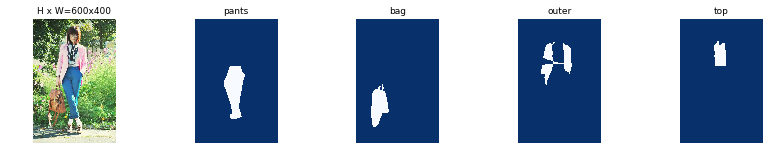

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/1019907.jpg
4
4


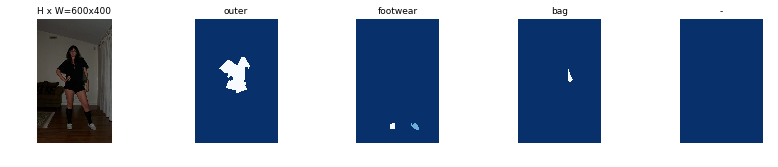

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/1023341.jpg
7
7


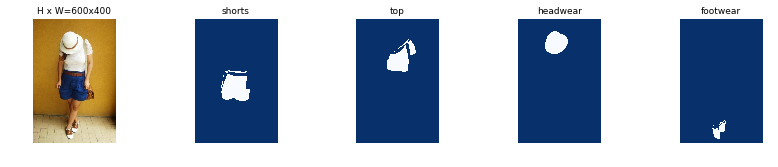

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/502360.jpg
5
5


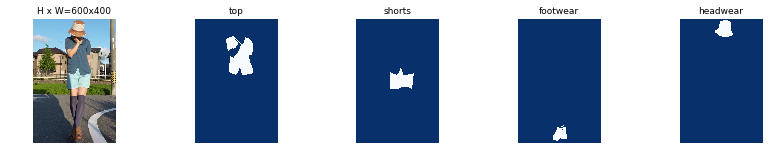

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/422747.jpg
5
5


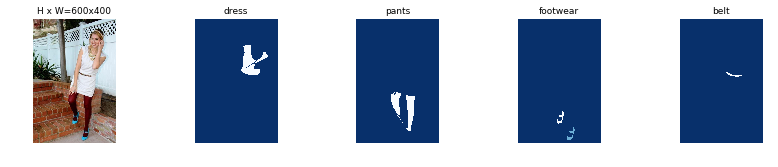

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/711666.jpg
3
3


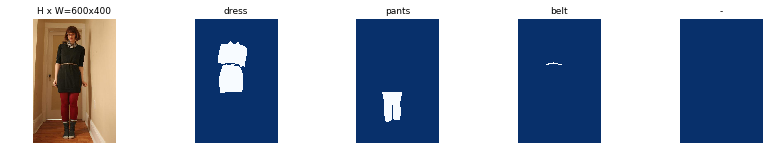

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/245095.jpg
4
4


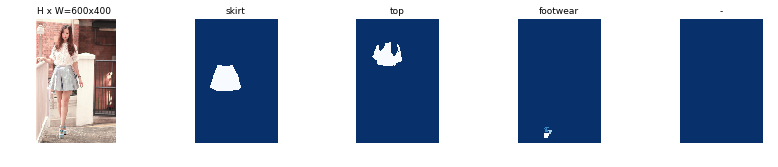

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/504790.jpg
9
9


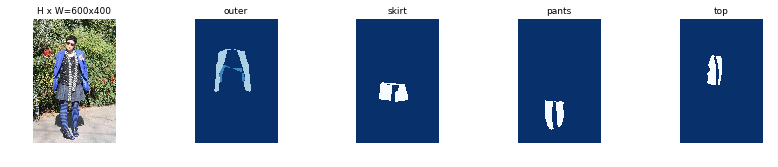

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/534533.jpg
6
6


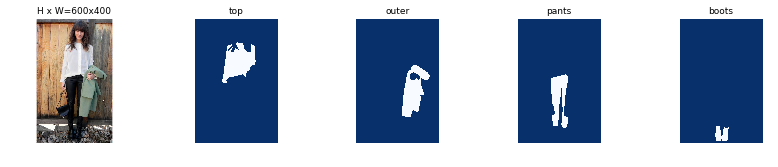

/content/drive/My Drive/TCC/modanet/modanet/annotations/test/7580.jpg
6
6


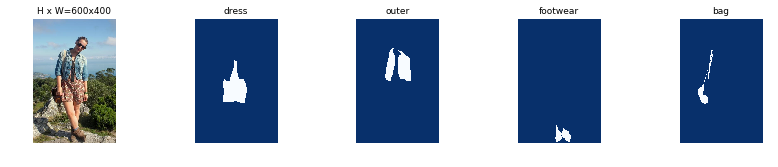

In [ ]:
image_ids = np.random.choice(dataset.image_ids,10)
for image_id in image_ids:
  print(dataset.image_reference(image_id))
  image = dataset.load_image(image_id)
  mask, class_ids = dataset.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

####Bounding Box

image_id  755 /content/drive/My Drive/TCC/modanet/modanet/annotations/test/839916.jpg
image                    shape: (600, 400, 3)         min:   44.00000  max:  255.00000  uint8
mask                     shape: (600, 400, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  213.00000  max:  507.00000  int32


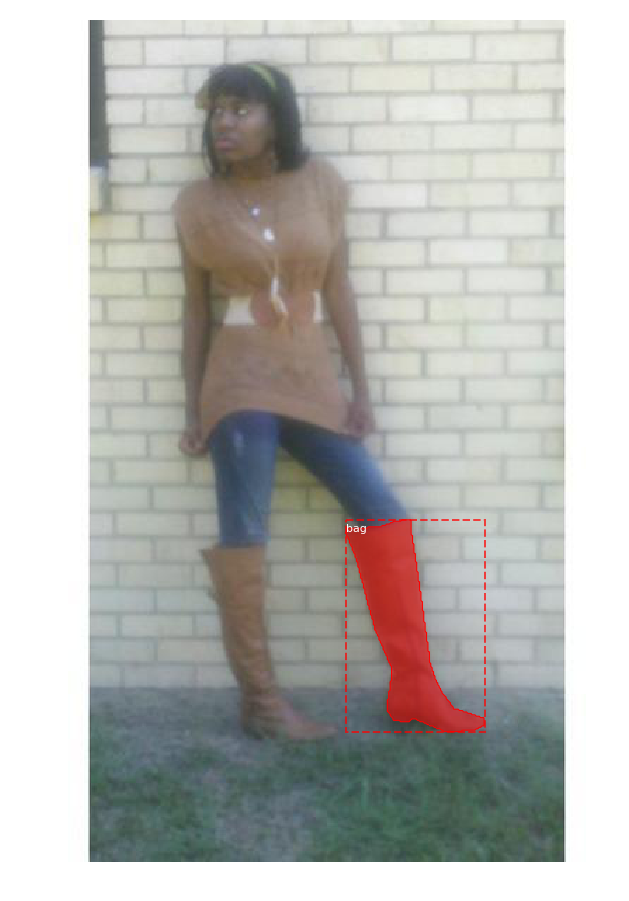

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

####Resize

image_id:  3878 /content/drive/My Drive/TCC/modanet/modanet/annotations/test/361052.jpg
Original shape:  (600, 400, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  331.00000  max:  572.00000  int32


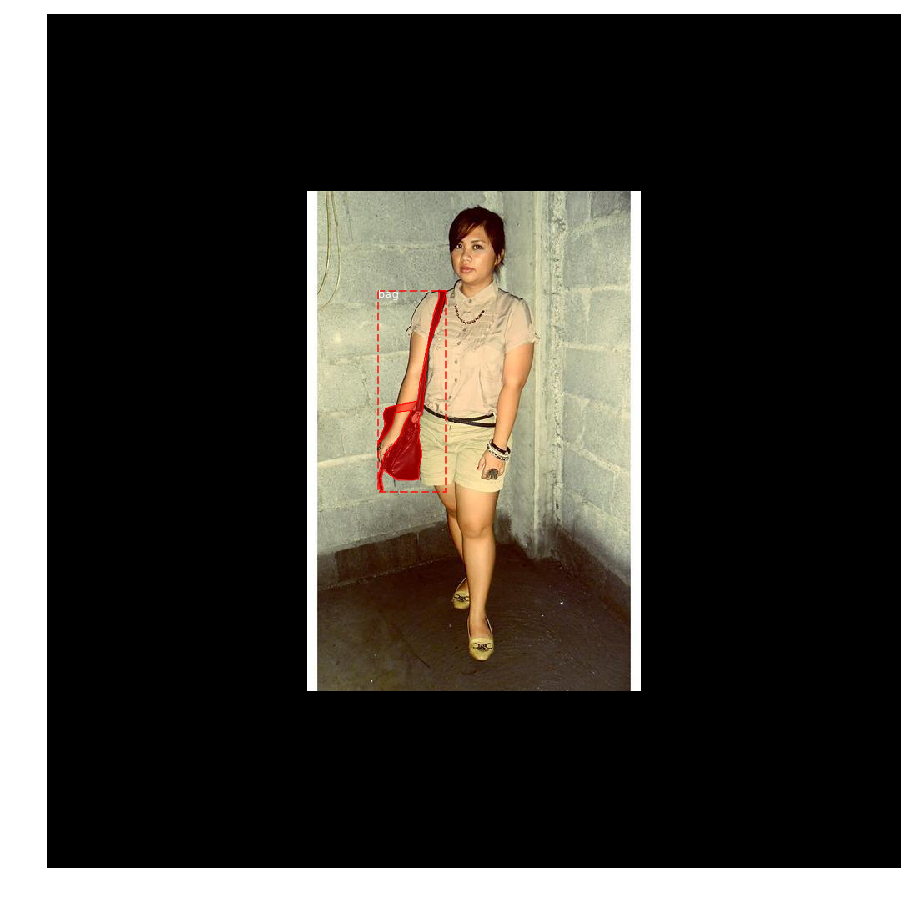

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, crop = utils.resize_image(image, 
                                                  min_dim=config.IMAGE_MIN_DIM, 
                                                  max_dim=config.IMAGE_MAX_DIM)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

####Mini-masks

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (26,)                 min:    1.00000  max: 2410.00000  int64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  430.00000  max:  811.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


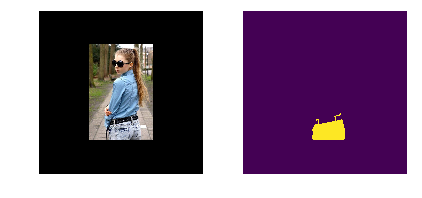

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset,
                                                              config, image_id)
log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

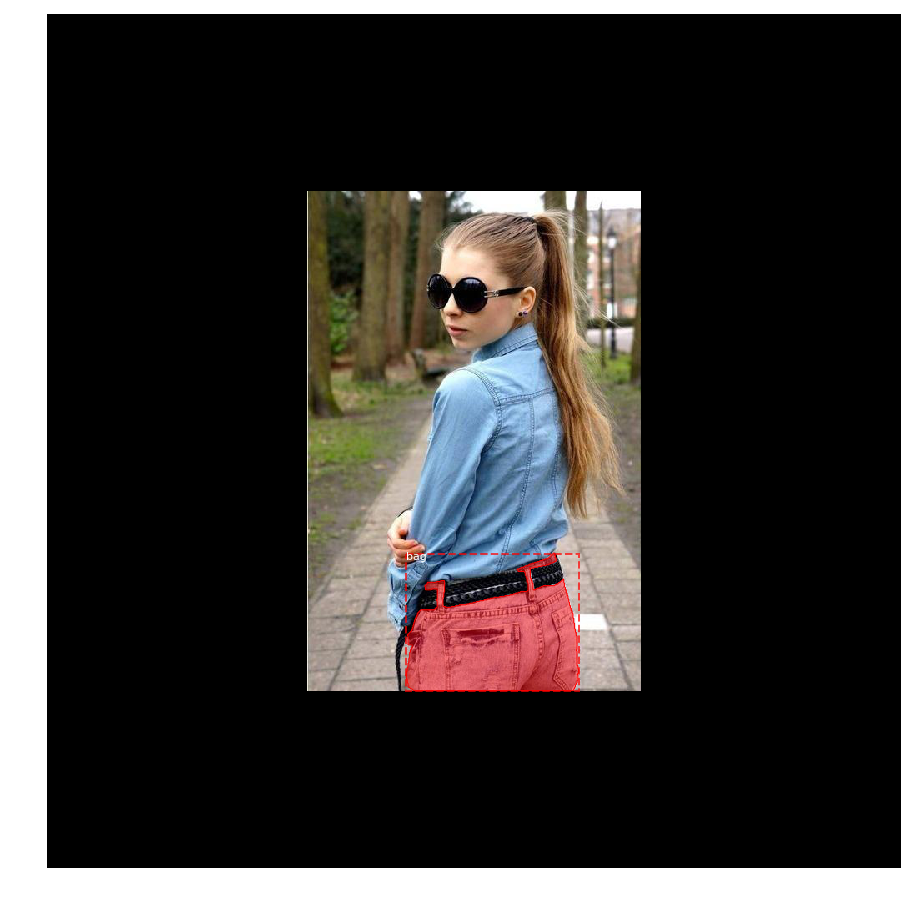

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


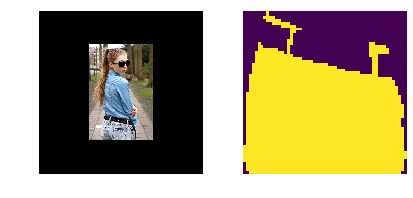

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

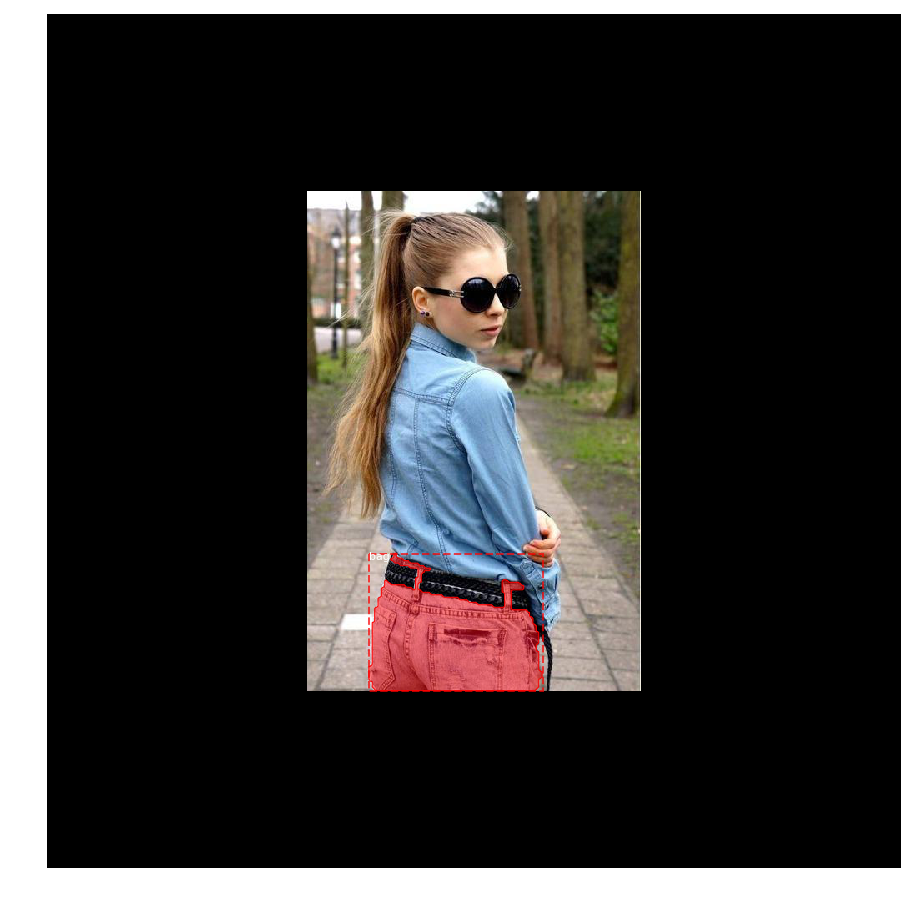

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

##Train

In [ ]:
def train(model):
    # Training dataset.
    dataset_train = ModaNetDataset()
    dataset_train.load_moda(args_dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = ModaNetDataset()
    dataset_val.load_moda(args_dataset, "val")
    dataset_val.prepare()

    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

In [ ]:
args_command = 'train'
#args_weights = "coco" 
args_weights = "imagenet"
args_dataset = "/content/drive/My Drive/TCC/modanet/modanet/annotations"
args_logs = "/content/drive/My Drive/TCC/Train/logs/"
#args-image = "path or URL to image"
#args-video = ''
# Prepare dataset
dataset_train = ModaNetDataset()
dataset_train.load_moda(args_dataset, "train")
dataset_train.prepare()

print("Images for training: {}".format(len(dataset_train.image_ids)))

Images for training: 41880


In [ ]:
# Validation dataset
dataset_val = ModaNetDataset()
dataset_val.load_moda(args_dataset, "val")
dataset_val.prepare()
print("Images for validation: {}".format(len(dataset_val.image_ids)))

Images for validation: 5331


In [ ]:
# Configurations
config = modanetConfig()

# Create model
if args_command == "train":
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=args_logs)
else:
    model = modellib.MaskRCNN(mode="inference", config=config,
                              model_dir=args_logs)
# Select weights file to load
if args_weights == "coco":
    weights_path = COCO_WEIGHTS_PATH
elif args_weights == "last":
    # Find last trained weights
    weights_path = model.find_last()
elif args_weights == "imagenet":
    # Start from ImageNet trained weights
    weights_path = model.get_imagenet_weights()
else:
    weights_path = args_weights
# Load weights
print("Loading weights ", weights_path)
if args_weights == "coco":
    # Exclude the last layers because they require a matching
    # number of classes
    model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits",
                                                            "mrcnn_bbox_fc",
                                                            "mrcnn_bbox",
                                                            "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
94658560/94653016 [==============================] - 1s 0us/step
Loading weights  /root/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5








In [ ]:
############################################################
#                        Training
############################################################

if args_command == "train":
    #train(model)
    print("Training network heads")
    print("================================================================================================")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')
    
    print("================================================================================================")
    print("Done Training!")
'''
elif args_command == "splash":
    detect_and_color_splash(model, image_path=args_image,
                            video_path=args_video)
else:
    print("'{}' is not recognized. "
          "Use 'train' or 'splash'".format(args_command))
'''

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/TCC/Train/logs/modanet20191116T1227/mask_rcnn_modanet_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_con

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/30
5
5
5
5
4
4
4
4
6
6
6
6
5
5
5
5
5
5
5
5
4
4
4
4
8
8
8
8
5
5
5
5
5
5
5
5
7
7
7
7
4
4
4
4
6
6
6
6
7
7
7
7
3
3
3
3
5
5
5
5
6
6
6
6
5
5
5
5
3
3
3
3
6
6
6
6
4
4
4
4
7
7
7
7
2
2
2
2
4
4
4
4
4
4
4
4
6
6
6
6
2
2
2
2
1
1
1
1
5
5
5
5
5
5
5
5
4
4
4
4
7
7
7
7
7
7
7
7
4
4
4
4
2
2
2
2
6
6
6
6
5
5
5
5
5
5
5
5
2
2
2
2
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
7
7
7
7
5
5
5
5
5
5
5
5
5
5
5
5
1
1
1
1
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
9
9
5
5
9
5
5
9
7
7
7
7
7
7
7
7
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
  1/200 [..............................] - ETA: 2:02:22 - loss: 7.1407 - rpn_class_loss: 1.6071 - rpn_bbox_loss: 1.5066 - mrcnn_class_loss: 2.3689 - mrcnn_bbox_loss: 0.9215 - mrcnn_mask_loss: 0.73655
5
5
5
5
5
5
5
  2/200 [..............................] - ETA: 1:02:34 - loss: 6.8009 - rpn_class_loss: 1.5706 - rpn_bbox_loss: 1.4904 - mrcnn_class_loss: 2.0542 - mrcnn_bbox_loss: 0.9500 - mrcnn_mask_loss: 0.73575
5
5
5
3
3
3
3
  3/200 [..............................] - ETA: 42:39 - loss: 6.5673 - rpn_class_loss: 

'\nelif args_command == "splash":\n    detect_and_color_splash(model, image_path=args_image,\n                            video_path=args_video)\nelse:\n    print("\'{}\' is not recognized. "\n          "Use \'train\' or \'splash\'".format(args_command))\n'